In [1]:
import autoreload
%load_ext autoreload
%autoreload 2  # Autoreload all modules

In [2]:
import sys
import os
import importlib
import localSettings as ls
importlib.reload(ls)
print(ls.main_path)
print(ls.SAMPLE)

C:\Users\Ryan\python-workspace\PeLEE-newmcfilteredsamples\
0304_numupresel


In [3]:
main_path = ls.main_path
sys.path.append(main_path)

In [4]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 04252020


## Change cell below to indicate whether doing run 3
### ISRUN3 = False implies Run1 (for now)

In [5]:
# Doing Run3?
ISRUN3 = True
ISG1 = True

In [6]:
import plotter
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
#import xgboost as xgb
#import nue_booster 
#importlib.reload(nue_booster)
import awkward

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

## Load Dataframes

In [7]:
#This cell loads dataframes
importlib.reload(ls)

tree = "NeutrinoSelectionFilter"

BNB = ""
EXT = ""
NU  = ""
DRT = ""

if ISRUN3:
    if not ISG1:
        BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good_reco2_1e19'+ls.APPEND
    if ISG1:
        BNB = 'neutrinoselection_filt_G1'
        BNB_7e18 = 'data_bnb_mcc9.1_v08_00_00_25_reco2_G1_beam_good_reco2_1e19'+ls.APPEND
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_G1_all_reco2'+ls.APPEND
    #EXT = 'ext'+ls.APPEND
    NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run3_reco2_G_reco2'+ls.APPEND
    DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run3_reco2_reco2'+ls.APPEND
    
else:
    BNB = 'data_bnb_mcc9.1_v08_00_00_25_reco2_C1_beam_good_reco2_5e19'+ls.APPEND
    EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_C1_all_reco2'+ls.APPEND
    #EXT = 'data_extbnb_mcc9.1_v08_00_00_25_reco2_all_reco2'+ls.APPEND #Run1 + Run2
    NU  = 'prodgenie_bnb_nu_uboone_overlay_mcc9.1_v08_00_00_26_filter_run1_reco2_reco2'+ls.APPEND
    DRT = 'prodgenie_bnb_dirt_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2'+ls.APPEND

if ISRUN3:
    RUN = ls.RUN3
else:
    RUN = ls.RUN1
    
mc = uproot.open(ls.ntuple_path+RUN+NU+".root")[ls.fold][tree]
if ISG1: data_7e18 = uproot.open(ls.ntuple_path+RUN+BNB_7e18+".root")[ls.fold][tree]
data = uproot.open(ls.ntuple_path+RUN+BNB+".root")[ls.fold][tree]
ext = uproot.open(ls.ntuple_path+RUN+EXT+".root")[ls.fold][tree]
dirt = uproot.open(ls.ntuple_path+RUN+DRT+".root")[ls.fold][tree]

uproot_v = [mc,ext,data,dirt]

variables = [
    #"shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "shr_theta",
    "selected", "nu_pdg",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category","shr_theta",
    "topological_score",
    #"shr_energy_tot", 
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    #"run","sub","evt",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    #"trk_pfp_id",
    "trk_llr_pid_score_v", # trk-PID score
    "trk_energy_proton_v", # track energy under proton hyp
    "trk_energy_muon_v", # track energy under muon hyp
    "trk_calo_energy_y_v", # track calo energy
    #"pi0_energy2_Y", # pi0 tagger variables
    'true_nu_vtx_x','true_nu_vtx_y','true_nu_vtx_z',
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nmuon",
    "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", 
    #"trk_hits_tot",
    #"matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0","npion","pion_e","muon_e","pi0truth_elec_etot","true_e_visible",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction",
    "trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
    "trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
    "trk_mcs_muon_mom_v","trk_range_muon_mom_v", "trk_len_v",
    "pfp_generation_v","trk_distance_v","trk_theta_v",
    "trk_energy_muon","trk_energy_tot","trk_energy",
    "pfnhits","pfnunhits"
]
#for numu selection
#the big G1 file is a picky eater
G1_variables = [
    "nslice", "selected", "nu_pdg",
    "slpdg", "trk_score_v","slclustfrac",
    #"contained_fraction",
    "backtracked_pdg","category",
    "topological_score",
    "crtveto","crthitpe","_closestNuCosmicDist","CosmicIP",
    "run", "sub", "evt",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "trk_sce_start_x_v","trk_sce_start_y_v","trk_sce_start_z_v",
    "trk_sce_end_x_v","trk_sce_end_y_v","trk_sce_end_z_v",
    "trk_mcs_muon_mom_v","trk_range_muon_mom_v", "trk_len_v",
    'trk_llr_pid_score_v',
    "pfp_generation_v","trk_distance_v","trk_theta_v",
    #"trk_energy_muon","trk_energy_tot","trk_energy",
    'trk_energy_muon_v','trk_energy_proton_v',
    "pfnhits","pfnunhits",
    'slnunhits','slnhits'
]
#make the list unique
variables = list(set(variables))
print(variables)

if not ISRUN3:
    variables.remove("_closestNuCosmicDist")
    variables.remove("crtveto")
    variables.remove("crthitpe")
    
WEIGHTS = ["weightSpline","weightTune","weightSplineTimesTune","leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
#WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
           "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
           "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]
MCVARS = [
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
]
SYSTEMATICS = []# ['weightsFlux','weightsGenie']


if ISG1:
    data = data.pandas.df(G1_variables, flatten=False)
    data_7e18 = data_7e18.pandas.df(variables, flatten=False)
else:
    data = data.pandas.df(variables, flatten=False)
print("Data dataframe built...")
mc = mc.pandas.df(variables + WEIGHTS + MCFVARS + SYSTEMATICS + MCVARS, flatten=False)
print("MC dataframe built...")
ext = ext.pandas.df(variables, flatten=False)
print("EXT dataframe built...")
dirt = dirt.pandas.df(variables + WEIGHTS + SYSTEMATICS + MCVARS, flatten=False)
print("Dirt dataframe built...")

['NeutrinoEnergy2', 'trk_energy_proton_v', 'trk_distance', 'shr_distance', 'interaction', 'crthitpe', 'pfp_generation_v', 'hits_ratio', 'shr_pz', 'slnunhits', 'shr_theta', 'shr_score', 'nu_e', 'pi0truth_elec_etot', 'trk_energy_tot', 'shr_energy', 'trk_theta_v', 'crtveto', 'topological_score', 'reco_nu_vtx_x', 'shr_dedx_V', 'trk_calo_energy_y_v', 'selected', 'sub', 'run', 'shr_tkfit_dedx_U', 'reco_nu_vtx_sce_y', 'best_obviouscosmic_flashmatch_score', 'CosmicDirAll3D', 'trk_mcs_muon_mom_v', 'nu_flashmatch_score', 'trk_sce_end_y_v', 'n_showers_contained', 'evt', 'trk_len_v', 'evnunhits', 'pi0_e', 'shr_phi', 'npion', 'shr_pfp_id_v', 'nmuon', 'n_tracks_contained', 'CosmicIP', 'true_nu_vtx_z', 'trk_energy', 'mc_pdg', 'shr_hits_tot', 'trk_energy_muon_v', 'trk_chipr', 'shr_dedx_Y_cali', 'slnhits', 'shr_tkfit_dedx_V', 'nproton', 'backtracked_pdg', 'pfnunhits', 'hits_y', 'nslice', 'pfnhits', 'true_nu_vtx_x', 'nu_pdg', 'trk_energy_muon', 'category', 'trk_theta', 'trk_bkt_pdg', 'trk_llr_pid_score_

In [8]:
#some scaling-related calculations

df_v = [mc,dirt]

for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    #df['weightSpline']  = df['weightSpline']  * df['weightTune']
    #df.loc[ df['npi0'] > 0, 'weightSplineTimesTune' ] = df['weightSpline'] * df['weightTune'] * 0.7 #scale down pi0s

In [ ]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# can be done for any variable
# code from Giuseppe!

df_v = [mc,ext,data,dirt]

for i,df in enumerate(df_v):
    print(i)
    up = uproot_v[i] #uproot_v are the uproot objects, not DataFrames
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['trkthetacos'] = np.cos(df['trk_theta'])
    #df['FMdiffOBV'] = df['nu_flashmatch_score']-df['best_obviouscosmic_flashmatch_score']
    #df['FMdiff'] = df['nu_flashmatch_score']-df['best_cosmic_flashmatch_score']

In [9]:
#
df_v = [mc,ext,data,dirt]
if ISG1: df_v.append(data_7e18)
    
for i,df in enumerate(df_v):
    df["slclnhits"] = df["pfnhits"].apply(lambda x: sum(x))
    df["slclnunhits"] = df["pfnunhits"].apply(lambda x: sum(x))
#

In [10]:
#Ryan's calculated columns and various necessities
df_v = [mc,ext,data,dirt]
if ISG1: df_v.append(data_7e18)

M_mu = 0.105 #GeV/c
M_p = 0.938 #GeV/c
proton_pidscore = 0.0

for i,df in enumerate(df_v):
    print(i)
    df['trk_p_quality_v'] = (df['trk_mcs_muon_mom_v']-df['trk_range_muon_mom_v'])/df['trk_range_muon_mom_v']
    df['trk_cos_v'] = df['trk_theta_v'].apply(lambda x: np.cos(x))
    df['trk_range_muon_e_v'] = (df['trk_range_muon_mom_v']**2 + M_mu**2)**.5 # E
    df['trk_range_muon_ke_v'] = df['trk_range_muon_e_v'] - M_mu #KE
    if ISG1:
        df['trk_energy_tot'] = df["trk_energy_proton_v"].apply(lambda x: sum(x)) #is missing from open sample
    else:
        df['reco_nu_e_range'] = df["trk_energy_muon"] + (df["trk_energy_tot"] - df["trk_energy"]) + M_mu
        
    df['reco_nu_e_range_v'] = df["trk_range_muon_e_v"] + (df["trk_energy_tot"] - df["trk_energy_proton_v"])     
    df['reco_nproton'] = df['trk_llr_pid_score_v'].apply(lambda x: len(x[x<proton_pidscore]) + 0.01) #add the 0.1 to prevent issue later
    
    #This information is useful for applying corrections and such
    if i == 2 or i == 4: df['bnbdata'] = 1
    else: df['bnbdata'] = 0
    if i == 1: df['extdata'] = 1
    else: df['extdata'] = 0
    if i in [1,2,4]:
        #column needs to exist, even if not cut on 
        df['_opfilter_pe_beam'] = -999
        df['_opfilter_pe_veto'] = 999
    if i not in [0,3]:
        #only apply to data and ext
        df.loc[(df['run'] > 16300),'crthitpe'] = df['crthitpe']*1.09 #hitpe correction

0
1
2
3
4


In [ ]:
INTERCEPT = 0.0
SLOPE = 0.83

# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
data["bnbdata"] = np.ones_like(data["shr_energy"])
ext["extdata"] = np.ones_like(ext["shr_energy"])

In [11]:
# add back the cosmic category
# and calculate Nproton multiplicity if you so desire
NPROTON_CAT = True
df = mc
df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
if NPROTON_CAT:
    df.loc[(df['category']==2)&(df['nproton']==0), 'category'] = 22
    df.loc[(df['category']==2)&(df['nproton']==1), 'category'] = 23
    df.loc[(df['category']==2)&(df['nproton']==2), 'category'] = 24
    df.loc[(df['category']==2)&(df['nproton']>=3), 'category'] = 25

In [12]:
nue = mc.query('nu_pdg == 12 or nu_pdg == -12')
mc  = mc.query('nu_pdg == 14 or nu_pdg == -14')
#lee = nue

In [ ]:
#lee["is_signal"] = lee["category"] == 11
data["is_signal"] = data["category"] == 11
#nue["is_signal"] = nue["category"] == 11
mc["is_signal"] = mc["category"] == 11
dirt["is_signal"] = dirt["category"] == 11
ext["is_signal"] = ext["category"] == 11

#lee.loc[lee['category'] == 1, 'category'] = 111
#lee.loc[lee['category'] == 10, 'category'] = 111
#lee.loc[lee['category'] == 11, 'category'] = 111


# Beginning of analysis section
### Setup, define useful functions

In [17]:
import plotter
import importlib
import pandas as pd
import matplotlib.backends.backend_pdf
import NUMUhelper
importlib.reload(plotter)
importlib.reload(NUMUhelper)

<module 'NUMUhelper' from 'C:\\Users\\Ryan\\python-workspace\\PELEE-newmcfilteredsamples\\NUMUhelper.py'>

In [15]:
samples = {
    "mc": mc,
    "nue": nue,
    "data": data,
    "ext": ext,
    "dirt": dirt,
    #"lee": lee,
}
scaling = 1
weights, pot = NUMUhelper.get_scaling(ISRUN3,ISG1, scaling)
if ISG1:
    data_1e20 = data
    weights_1e20 = weights
    pot_1e20 = pot
my_plotter = plotter.Plotter(samples, weights, pot=pot)


In [18]:
#updated for SCE
#will swap numerical vals at end   systematic boundaries
FVx = [5,251]                      #[10,246]
FVy = [-110,110]                   #[-105,105]
FVz = [20,986]                     #[25,986]

def get_NUMU_sel(verbose=False):
    # muon selection
    QUERY = 'nslice == 1'
    #if ISRUN3: QUERY += ' and ((crtveto!=1) or (crthitpe < 100)) and (_closestNuCosmicDist > 20.)'
    #QUERY += ' and trk_len > 20'
    QUERY += ' and topological_score > 0.06'
    QUERY += ' and reco_nu_vtx_sce_x > FVx[0] and reco_nu_vtx_sce_x < FVx[1]'
    QUERY += ' and reco_nu_vtx_sce_y > FVy[0] and reco_nu_vtx_sce_y < FVy[1]'
    QUERY += ' and reco_nu_vtx_sce_z > FVz[0] and reco_nu_vtx_sce_z < FVz[1]'
    QUERY += ' and ( (reco_nu_vtx_sce_z < 675) or (reco_nu_vtx_sce_z > 775) )' #avoid dead wire region
    #QUERY += ' and trkpid > 0.5'
    #QUERY += ' and (trkthetacos < 0.853 or trkthetacos > 0.8531)'
    #QUERY += ' and bkpdg == 2212 and (trkcompl < 0.5 or trkpur < 0.5)'
    if ISRUN3:
        QUERY += ' and (crtveto!=1 or crthitpe < 100.) and (_closestNuCosmicDist > 5.)' # Note: CRTs weren't installed for until after Run 1
    QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
    
    #okay, so the track level cuts are a bit more complicated
    #can't just use query. Gotta do each cut one at a time
    #(variable (must end in _v), operation, value)
    track_cuts = [
        ('trk_sce_start_x_v', '>', FVx[0]),
        ('trk_sce_start_x_v', '<', FVx[1]),
        ('trk_sce_start_y_v', '>', FVy[0]),
        ('trk_sce_start_y_v', '<', FVy[1]),
        ('trk_sce_start_z_v', '>', FVz[0]),
        ('trk_sce_start_z_v', '<', FVz[1]),
        ('trk_sce_end_x_v', '>', FVx[0]),
        ('trk_sce_end_x_v', '<', FVx[1]),
        ('trk_sce_end_y_v', '>', FVy[0]),
        ('trk_sce_end_y_v', '<', FVy[1]),
        ('trk_sce_end_z_v', '>', FVz[0]),
        ('trk_sce_end_z_v', '<', FVz[1]),
        ('trk_p_quality_v', '>', -0.5),
        ('trk_p_quality_v', '<', 0.5),
        ('trk_llr_pid_score_v', '>', 0.2),
        ('trk_score_v', '>', 0.8),
        ('trk_len_v', '>', 10),
        ('pfp_generation_v', '==', 2),
        ('trk_distance_v', '<', 4)
    ]

    QUERY = QUERY.replace('FVx[0]',str(FVx[0]))
    QUERY = QUERY.replace('FVy[0]',str(FVy[0]))
    QUERY = QUERY.replace('FVz[0]',str(FVz[0]))
    QUERY = QUERY.replace('FVx[1]',str(FVx[1]))
    QUERY = QUERY.replace('FVy[1]',str(FVy[1]))
    QUERY = QUERY.replace('FVz[1]',str(FVz[1]))

    if verbose:
        print ("QUERY:\n {}\n".format(QUERY))
        print("track_cuts:\n{}".format(track_cuts))

    return QUERY,track_cuts

#if both the data samples are loaded, have a way to switch between them
def update_data(data_sample):
    print("updating data sample to {}...".format(data_sample))
    if data_sample == "G1":
        data = data_1e20
        weights,pot = NUMUhelper.get_scaling(ISRUN3, True)
    elif data_sample == "7e18":
        data = data_7e18
        weights,pot = NUMUhelper.get_scaling(ISRUN3, False)

    samples['data'] = data
    return samples, weights, pot

def Eff(df, df_cut, var,acceptance,bin_edges,absval=False):
    #print acceptance
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_eff = []
    bin_err = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = "{} > {} and {} < {}".format(var,binmin,var,binmax)
        if (absval == True):
            bincut = '(%s > %f and %s < %f) or (%s > -%f and %s < -%f)'%(var,binmin,var,binmax,var,binmax,var,binmin)
        #print bincut
        df_tmp =  df.query(bincut).query(acceptance) # denominator
        df_sub = df_cut.query(bincut).query(acceptance) # numerator

        if (df_tmp.shape[0] == 0): continue
        eff = df_sub.shape[0] / float( df_tmp.shape[0] )
        err = np.sqrt( eff*(1-eff)/df_tmp.shape[0] )
        bin_eff.append( eff )
        bin_err.append( err )
        bins.append(bin_centers[i])
        #print 'eff = %.02f @ bin = %.02f'%(eff,bin_centers[i])
    return np.array(bins),np.array(bin_eff),np.array(bin_err)

def Pur(samples, weights, var, acceptance, binedges):
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_pur = []
    bin_err = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = "{} > {} and {} < {}".format(var,binmin,var,binmax)
        df_num = samples['mc'].query(bincut).query(acceptance)
        num = df_num.shape[0]*weights['mc']
        den = 0
        for sample in ['mc','dirt','ext','nue']:
            den += samples[sample].query(bincut).shape[0]*weights[sample]
        pur = num * 1.0 / den
        err = np.sqrt(pur*(1-pur)/den)
        bin_pur.append(pur)
        bin_err.append(err)
        bins.append(bin_centers[i])
    return np.array(bins), np.array(bin_pur), np.array(bin_err)

In [ ]:
#######################################
# Get DFs of final selection
# Will save time down the road since it takes FOREVER to implement track cuts
######################################

def get_fullsel_index(DF):
    '''
    Returns dataframe will all cuts applied
    '''
    query, track_cuts = get_NUMU_sel()
    df = DF.copy().query(query)
    mask = df['trk_len_v'].apply(lambda x: x==x) #all true mask
    #apply track cuts using mask
    for (var,op,val) in track_cuts:
        if type(op) == list:
            #relate the two operations with an 'or'
            or_mask1 = df[var].apply(lambda x: eval("x{}{}".format(op[0],val[0])))#or condition 1
            or_mask2 = df[var].apply(lambda x: eval("x{}{}".format(op[1],val[1])))#or condition 2
            mask *= (or_mask1 + or_mask2) #just add the booleans for "or"
        else:
            mask *= df[var].apply(lambda x: eval("x{}{}".format(op,val))) #layer on each cut mask
    VAR = (df['trk_len_v']*mask).apply(lambda x: x[x != False]) #apply mask to dummy var
    VAR = VAR[VAR.apply(lambda x: len(x) > 0)] #clean up empty slices
    return VAR.index

def get_presel_index(DF):
    '''
    Returns dataframe will all cuts applied
    '''
    query, track_cuts = get_NUMU_sel()
    df = DF.copy().query(query)
    VAR = df['trk_len_v'] #any variable will do
    return VAR.index

### prep the preselected dataframes

In [ ]:
fullsel_indices = {
    'mc': get_fullsel_index(mc),
    'nue': get_fullsel_index(nue),
    'dirt': get_fullsel_index(dirt),
    'data': get_fullsel_index(data),
    'ext': get_fullsel_index(ext)
}

fullsel_samples = {
    'mc': mc.loc[fullsel_indices['mc']],
    'nue': nue.loc[fullsel_indices['nue']],
    'dirt': dirt.loc[fullsel_indices['dirt']],
    'data': data.loc[fullsel_indices['data']],
    'ext': ext.loc[fullsel_indices['ext']],
}

In [ ]:
presel_indices = {
    'mc': get_presel_index(mc),
    'nue': get_presel_index(nue),
    'dirt': get_presel_index(dirt),
    'data': get_presel_index(data),
    'ext': get_presel_index(ext)
}
presel_samples = {
    'mc': mc.loc[presel_indices['mc']],
    'nue': nue.loc[presel_indices['nue']],
    'dirt': dirt.loc[presel_indices['dirt']],
    'data': data.loc[presel_indices['data']],
    'ext': ext.loc[presel_indices['ext']],
}

# Export Data Files for Constraint

In [ ]:
#select the longest track for the dataframes
#only need to do this for variables of interest
variables = ['trk_theta_v','trk_range_muon_e_v','reco_nu_e_range_v']

for sample in fullsel_samples.keys():
    df = fullsel_samples[sample]
    trk_lens = df['trk_len_v']
    longest_mask = trk_lens.apply(lambda x: x == x[list(x).index(max(x))]) #identify longest
    for variable in variables:
        VAR = df[variable]
        VAR = VAR.apply(lambda x: x[~np.isnan(x)]) #clean up nan vals
        VAR = VAR[VAR.apply(lambda x: len(x) > 0)]
        VAR = (VAR*longest_mask).apply(lambda x: x[x != False]) #apply longest mask
        if len(VAR.iloc[0]) == 1:
            VAR = VAR.apply(lambda x: x[0])
            #apply this new column
            new_variable = variable[:-2]
            df[new_variable] = VAR
        else:
            print('something is wrong...')
            print(VAR)
    

In [ ]:
#want to spit out the bin counts for full selection
binedges = np.linspace(0.15,1.55,15)
print("binedges:{}".format(binedges))

for s,sample in enumerate(fullsel_samples):
    print(sample)
    df = fullsel_samples[sample].copy()
    binvals,_ = np.histogram(df['reco_nu_e_range'], bins=binedges)
    print(binvals," -> ",sum(binvals))
        

In [ ]:
#get the events that pass the selection cuts

SAVEPATH = "passing_events\\{}{}_G1\\".format(RUN,ls.SAMPLE)
if not os.path.exists(SAVEPATH):
    os.makedirs(SAVEPATH)

for sample in fullsel_samples.keys():
    print(sample)
    f_out = open(SAVEPATH+"{}_042220_Passingevents.txt".format(sample),'w')
    df = fullsel_samples[sample]
    
    print ('file %s_final has %i selected entries'%(sample,df.shape[0]))
    f_out.write('%s\t%s\t%s\t%s\t%s\t%s\n'%('run','sub','evt','angle','Emuon','Erange'))
    for i,row in df.iterrows():
        run = row['run']
        sub = row['sub']
        evt = row['evt']
        angle = row['trk_theta']
        Emuon = row['trk_range_muon_e']
        Erange = row['reco_nu_e_range']
        f_out.write('%i\t%i\t%i\t%.4f\t%.4f\t%.4f\n'%(run,sub,evt,angle,Emuon,Erange))
    f_out.close()



# Plotting

#### Efficiency and Purity

In [ ]:
SAVEFIG = False

eff_samples = ['mc']
pur_samples = ['mc','dirt','nue','ext']
signal = 'abs(nu_pdg) == 14 and ccnc == 0'
signal += ' and nmuon==1'
signal += ' and true_nu_vtx_x > {} and true_nu_vtx_x < {}'.format(FVx[0],FVx[1])
signal += ' and true_nu_vtx_y > {} and true_nu_vtx_y < {}'.format(FVy[0],FVy[1])
signal += ' and true_nu_vtx_z > {} and true_nu_vtx_z < {}'.format(FVz[0],FVz[1])
bin_edges = np.linspace(0.15,1.55,15)
df = samples['mc'] #unbiased denominator
df_cut = samples['mc'].query() #selected numerator
 
bins,bin_eff,bin_err = Eff(df,df_cut,'nu_e',signal,bin_edges) #get bin info
bin_eff, bin_err = list(bin_eff), list(bin_err)
overall_eff = np.sum(df_cut.query(signal).query('nu_e < 1.55')['nu_e']) / np.sum(df.query(signal).query('nu_e < 1.55')['nu_e'])
bin_eff.append(bin_eff[-1])
bin_err.append(bin_err[-1])
plt.step(bin_edges, 
         bin_eff, 
         where='post', label = "Efficiency: {}% overall".format(round(overall_eff*100,2)))
plt.fill_between(
        bin_edges,
        np.array(bin_eff)+np.array(bin_err),
        np.array(bin_eff)-np.array(bin_err),
        alpha=0.3, step='post')


bins,bin_pur,bin_err = Pur(fullsel_samples, weights, 'nu_e', signal, bin_edges)
bin_pur, bin_err = list(bin_pur), list(bin_err)
overall_pur = np.sum(df_cut.query(signal).query('nu_e > 0.15 and nu_e < 1.55')['nu_e']*weights['mc']) / (np.sum(df_cut.query('nu_e > 0.15 and nu_e < 1.55')['nu_e'])*weights['mc'] + np.sum(fullsel_samples['dirt'].query('nu_e > 0.15 and nu_e < 1.55')['nu_e'])*weights['dirt'] + np.sum(fullsel_samples['ext'].query('nu_e > 0.15 and nu_e < 1.55')['nu_e'])*weights['ext'] + np.sum(fullsel_samples['nue'].query('nu_e > 0.15 and nu_e < 1.55')['nu_e'])*weights['nue'])
bin_pur.append(bin_pur[-1])
bin_err.append(bin_err[-1])
plt.step(bin_edges, 
         bin_pur, 
         where='post', label = "Purity: {}% overall".format(round(overall_pur,4)*100))
#plt.fill_between(
#        bin_edges,
#        np.array(bin_pur)+np.array(bin_err),
#        np.array(bin_pur)-np.array(bin_err),
#        alpha=0.3, step='post')


plt.legend(fontsize=15)
plt.xlim([bin_edges[0],bin_edges[-1]])
plt.ylim([0,1])
plt.title("Efficiency and Purity")
plt.xlabel(r"True $\nu$ Energy [GeV]")
if SAVEFIG: plt.savefig('plots\\Run3\\0304\\pur-eff\\fullsel-presel_pur-eff.pdf')

## data-MC comparisons

In [ ]:
#########################
# Study G1 vs 7e18
########################
#active volume
AVx = [-1.55,254.8]
AVy = [-115.53, 117.47]
AVz = [0.1, 1036.9]

VARIABLE, BINS, RANGE, XTIT = 'crthitpe_fix', 25, (0.1,600), 'CRT hit PE (fixed data)'
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_e_range_v',14,(0.15,1.55),r'Reco Range-Based $\nu$ Energy [GeV]'

tag = "fullsel_G1_withoutMCS" #tag gets added to end of .png name
SAVEFIG = True
SAVEDIR = ls.plots_path+RUN+ls.SAMPLE+'\\NUESHAPE\\'

if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)
    
QUERY, track_cuts = get_NUMU_sel()

if "presel" in tag: track_cuts = None
if "Slice" in tag:
    QUERY = 'nslice == 1'
    track_cuts = None
if "7e18" in tag: samples, weights, pot = update_data("7e18")
if "G1" in tag: samples, weights, pot = update_data("G1")    
if "withoutmcs" in tag.lower():
    track_cuts.remove(('trk_p_quality_v', '>', -0.5))
    track_cuts.remove(('trk_p_quality_v', '<', 0.5))
    
importlib.reload(plotter)
my_plotter = plotter.Plotter(samples, weights, pot=pot)
    
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query=QUERY,#+" and category != 111",
    kind="event_category",
    #kind="sample", 
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys=False,
    stacksort=3,
    track_cuts = track_cuts,
    select_longest = True, #this is true by default in self._selection
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
)[0:3]

print("Profile likelihood: {} sigma @ {} POT".format(my_plotter.significance_likelihood,pot))
print("s/sqrt(b): {} sigma @ {} POT".format(my_plotter.significance, pot))

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,12000)
ax1.set_ylim(0,ax1.get_ylim()[1]*1.5)
#ax2.set_ylim(0.5,1.5)

if SAVEFIG:
    fn = VARIABLE+"_"+date_time+"_"+tag
    fn += ".pdf"
    print("saving to {}...".format(SAVEDIR+fn))
    fig.savefig(SAVEDIR+fn)
plt.show()

In [ ]:
###########################################
## Is neutrino E calculated consistently?
###########################################

samples, weights, pot = update_data("7e18")
importlib.reload(plotter)
my_plotter = plotter.Plotter(samples, weights, pot=pot)

varname1, varname2 = 'reco_nu_e_range', 'reco_nu_e_range_v'

QUERY, track_cuts = get_NUMU_sel()
QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
#track_cuts = None

tag = "fullsel_2d_res" #tag gets added to end of .png name
SAVEFIG = True
SAVEDIR = ls.plots_path+RUN+ls.SAMPLE+'\\NUESHAPE\\'

if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)

fig, axes = my_plotter.plot_2d(
                varname1,varname2,
                QUERY, track_cuts,
                range_x = (0.15,1.55),
                range_y = (0.15,1.55),
                bins_x = 50,
                bins_y = 50,
)

if SAVEFIG:
    fn = 'reco_nu_e'+"_"+date_time+"_"+tag
    fn += ".pdf"
    print("saving to {}...".format(SAVEDIR+fn))
    fig.savefig(SAVEDIR+fn)
plt.show()

In [ ]:
samples['mc'] = mc.sort_values(by='category')

In [ ]:
############################################
## Make just one plot with without ratio plot
############################################

#active volume
AVx = [-1.55,254.8]
AVy = [-115.53, 117.47]
AVz = [0.1, 1036.9]

VARIABLE, BINS, RANGE, XTIT = 'nu_e',14,(0.15,1.55),r'True $\nu$ Energy [GeV]'
VARIABLE, BINS, RANGE, XTIT = 'reco_nproton',5,(-0.5,4.5),r'Reco Proton Multiplicity'
#VARIABLE, BINS, RANGE, XTIT = 'nproton',5,(-0.5,4.5),r'True Proton Multiplicity'

#tag gets added to end of .pdf name and changes some parameters
#for example if "presel" is in the tag, no track_cuts will be applied
tag = "presel"
SAVEFIG = False
SAVEDIR = ls.plots_path+RUN+ls.SAMPLE+'\\proton-multiplicity\\'
#####################################################################


if VARIABLE not in samples['data'].keys():
    samples['data'][VARIABLE] = -999    
if "7e18" in tag.lower(): samples, weights, pot = update_data("7e18")
elif "g1" in tag.lower(): samples, weights, pot = update_data("G1")
importlib.reload(plotter)
my_plotter = plotter.Plotter(samples, weights, pot=pot) 

if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)

    
QUERY, track_cuts = get_NUMU_sel()
muon_fid = track_cuts[:12] #cuts associated with fiducializing the muon
#track_cuts = muon_fid
if "presel" in tag.lower(): track_cuts = None
if "fid" in tag.lower(): track_cuts = muon_fig
if "justsliceid" in tag.lower(): 
    QUERY,track_cuts = 'nslice == 1', None
    QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
if "withoutmcs" in tag.lower():
    track_cuts.remove(('trk_p_quality_v', '>', -0.5))
    track_cuts.remove(('trk_p_quality_v', '<', 0.5))

#######################################################
# plotting
print("QUERY: ", QUERY)
if track_cuts:
    print("track_cuts: ")
    for cut in track_cuts:
        try:
            print("{} {} {}".format(cut[0],cut[1],cut[2]))
        except:
            print("{} {} {} or {} {} {}".format(cut[0],cut[1][0],cut[2][0],cut[0],cut[1][1],cut[2][1]))
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query=QUERY,#+" and category != 111",
    kind="event_category",
    #kind="sample", 
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys=False,
    stacksort=0, #0-numerical, 1-weights, 2-eLee on top, 3-eLee+nue on top
    track_cuts = track_cuts,
    select_longest = True, #this is true by default in self._selection
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
    ratio=False,
)[0:3]

print("Profile likelihood: {} sigma @ {} POT".format(my_plotter.significance_likelihood,pot))
print("s/sqrt(b): {} sigma @ {} POT".format(my_plotter.significance, pot))

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,12000)
ax1.set_ylim(0,ax1.get_ylim()[1]*1.5)
#ax2.set_ylim(0.5,1.5)

if SAVEFIG:
    fn = VARIABLE+"_"+date_time+"_"+tag
    fn += ".pdf"
    print("saving to {}...".format(SAVEDIR+fn))
    fig.savefig(SAVEDIR+fn)
plt.show()

updating data sample to 7e18...
QUERY:  nslice == 1 and topological_score > 0.06 and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251 and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986 and ( (reco_nu_vtx_sce_z < 675) or (reco_nu_vtx_sce_z > 775) ) and (crtveto!=1 or crthitpe < 100.) and (_closestNuCosmicDist > 5.) and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)


E:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:720: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
E:\Anaconda3\lib\site-packages\numpy\lib\histograms.py:721: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Profile likelihood: 0 sigma @ 7.63e+18 POT
s/sqrt(b): 0 sigma @ 7.63e+18 POT


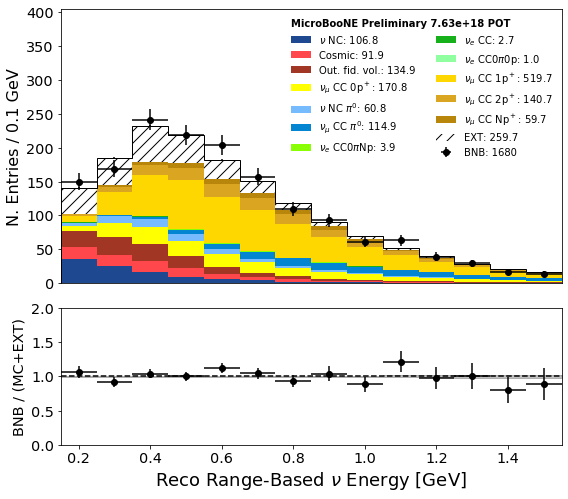

In [25]:
############################
## Make just one plot
###########################

if ISG1:
    samples, weights, pot = update_data("7e18")
importlib.reload(plotter)
my_plotter = plotter.Plotter(samples, weights, pot=pot)
#my_plotter = plotter.Plotter(fullsel_samples, weights, pot=pot)

#active volume
AVx = [-1.55,254.8]
AVy = [-115.53, 117.47]
AVz = [0.1, 1036.9]


#VARIABLE, BINS, RANGE, XTIT = 'trk_p_quality_v',24,(-1,2.5),r'MCS Consistency $(\frac{P_{MCS}-P_{Range}}{P_{Range}})$'
#VARIABLE, BINS, RANGE, XTIT = 'trk_sce_end_y_v',25,(AVy[0],AVy[1]),r"Reconstructed Muon Endpoint Y [cm]"
#VARIABLE, BINS, RANGE, XTIT = 'crthitpe', 25, (0.1,600), "CRT hit PE"
#VARIABLE, BINS, RANGE, XTIT = 'topological_score', 25, (0,1), 'Topological Score'
#VARIABLE, BINS, RANGE, XTIT = '_closestNuCosmicDist', 20, (1,10), r"Closest $\nu$-vertex distance [cm]"
##########################
# VARIABLES with detsys available
#VARIABLE, BINS, RANGE, XTIT = 'trk_len_v',24,(0,500),r'Track Length [cm]'
#VARIABLE, BINS, RANGE, XTIT = 'trk_cos_v',24,(-1,1),r'Cos($\theta$)'
VARIABLE, BINS, RANGE, XTIT = 'reco_nu_e_range_v',14,(0.15,1.55),r'Reco Range-Based $\nu$ Energy [GeV]'
#VARIABLE, BINS, RANGE, XTIT = 'trk_range_muon_e_v',10,(0.15,1.15),r'Reco Range-Based Muon Energy [GeV]'


#tag gets added to end of .pdf name and changes some parameters
#for example if "presel" is in the tag, no track_cuts will be applied
tag = "presel" 
    
SAVEFIG = False
DETSYS = False


SAVEDIR = ls.plots_path+RUN+ls.SAMPLE+'\\'
if 'fullsel' in tag:
    SAVEDIR += 'fullsel\\'
if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)
QUERY, track_cuts = get_NUMU_sel()
muon_fid = track_cuts[:12] #cuts associated with fiducializing the muon
#track_cuts = muon_fid
if "presel" in tag.lower(): track_cuts = None
if "fid" in tag.lower(): track_cuts = muon_fig
if "justsliceid" in tag.lower(): 
    QUERY,track_cuts = 'nslice == 1', None
    QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
# For Systematic Errors
#unpickle the most up-to-date systematic files, if available
#must have pickled data of this format available
PICKLEPATH = ls.main_path+ls.pickle_path+'NUMU-constr\\04072020\\'
pickle_tag = tag
pickle_name = "{}_{}_{}-{}-{}.pickle".format(VARIABLE,pickle_tag,RANGE[0],RANGE[1],BINS+1)
if DETSYS:
    try:
        df_detsys_mc = pd.read_pickle(PICKLEPATH+pickle_name)
        detsys = {
            'mc' : df_detsys_mc['sum_noRecomb'] #'sum_noRecomb' or 'sum_nodEdX'
        }
    except:
        detsys = None
        print("could not load detsys pickle...")
        print("...tried {}".format(PICKLEPATH+pickle_name))
else: detsys = None
    
    
#######################################################
# plotting
print("QUERY: ", QUERY)
if track_cuts:
    print("track_cuts: ")
    for cut in track_cuts:
        try:
            print("{} {} {}".format(cut[0],cut[1],cut[2]))
        except:
            print("{} {} {} or {} {} {}".format(cut[0],cut[1][0],cut[2][0],cut[0],cut[1][1],cut[2][1]))
fig, ax1, ax2 = my_plotter.plot_variable(
    VARIABLE,   
    query=QUERY,#+" and category != 111",
    kind="event_category",
    #kind="sample", 
    #kind="interaction",
    #kind='particle_pdg',
    draw_sys=False,
    stacksort=4,
    track_cuts = track_cuts,
    select_longest = True, #this is true by default in self._selection
    title=XTIT,
    #bins=asymm_bins,
    bins=BINS,
    range=RANGE,
    detsys=detsys,
)[0:3]

print("Profile likelihood: {} sigma @ {} POT".format(my_plotter.significance_likelihood,pot))
print("s/sqrt(b): {} sigma @ {} POT".format(my_plotter.significance, pot))

#ax1.set_ylim(0,40)
#ax1.set_yscale("log")
#ax1.set_ylim(0,12000)
ax1.set_ylim(0,ax1.get_ylim()[1]*1.5)
#ax2.set_ylim(0.5,1.5)

if SAVEFIG:
    fn = VARIABLE+"_"+date_time+"_"+tag
    if DETSYS:
        fn += "_detsys"
    fn += ".pdf"
    print("saving to {}...".format(SAVEDIR+fn))
    fig.savefig(SAVEDIR+fn)
plt.show()

In [ ]:
##################################
# Make several plots at once
# note the SAVEDIR before running cell
##################################

#reload helper script incase of changes
importlib.reload(plotter)
my_plotter = plotter.Plotter(samples, weights, pot=pot)

#potentially useful values
AVx = [-1.55,254.8]
AVy = [-115.53, 117.47]
AVz = [0.1, 1036.9]
FVx = [5,251]                      #[10,246]
FVy = [-110,110]                   #[-105,105]
FVz = [20,986]                     #[25,986]
M_mu = 0.105 #GeV/c

##### Edges hi-low FV study #########
muon_vars = [
    'trk_sce_start_x_v','trk_sce_start_y_v','trk_sce_start_z_v',
    'trk_sce_end_x_v','trk_sce_end_y_v','trk_sce_end_z_v',
    #'reco_nu_vtx_sce_x','reco_nu_vtx_sce_y','reco_nu_vtx_sce_z'
]
muon_bins = [26]*len(muon_vars)

muon_ranges_low = [
    (AVx[0]-3,FVx[0]+5),(AVy[0]-3,FVy[0]+5),(AVz[0]-3,FVz[0]+5),
    (AVx[0]-3,FVx[0]+5),(AVy[0]-3,FVy[0]+5),(AVz[0]-3,FVz[0]+5),
]
muon_ranges_high = [
    (FVx[1]-5,AVx[1]+3),(FVy[1]-5,AVy[1]+3),(FVz[1]-5,AVz[1]+3),
    (FVx[1]-5,AVx[1]+3),(FVy[1]-5,AVy[1]+3),(FVz[1]-5,AVz[1]+3),
]
muon_ranges = muon_ranges_high ######### high / low
muon_titles = [
    'Muon Candidate Start, X [cm]', 'Muon Candidate Start, Y [cm]', 'Muon Candidate Start, Z [cm]',
    'Muon Candidate End, X [cm]', 'Muon Candidate End, Y [cm]', 'Muon Candidate End, Z [cm]',
    #r'Reco Range-Based $\nu$ Vertex X [GeV]',r'Reco Range-Based $\nu$ Vertex Y [GeV]',r'Reco Range-Based $\nu$ Vertex Z [GeV]'
]

#all the variables cut on in the muon selection
muon_vars = [
    'trk_sce_start_x_v','trk_sce_start_y_v','trk_sce_start_z_v',
    'trk_sce_end_x_v','trk_sce_end_y_v','trk_sce_end_z_v',
    'trk_score_v','trk_llr_pid_score_v','trk_p_quality_v',
    'trk_len_v','trk_distance_v','pfp_generation_v'
]
muon_bins = [26]*len(muon_vars)
muon_bins[-1] = 5

muon_ranges = [
    (AVx[0],AVx[1]+1),(AVy[0]-1,AVy[1]+1),(AVz[0]-1,AVz[1]),
    (AVx[0],AVx[1]+1),(AVy[0]-1.5,AVy[1]+1.5),(AVz[0]-1,AVz[1]+.5),
    (0,1),(-1,1),(-1,2.5),
    (0,1000),(0,5),(-0.5,4.5)
]
muon_titles = [
    'Muon Candidate Start, X [cm]', 'Muon Candidate Start, Y [cm]', 'Muon Candidate Start, Z [cm]',
    'Muon Candidate End, X [cm]', 'Muon Candidate End, Y [cm]', 'Muon Candidate End, Z [cm]',
    'Track Score', 'Log-Likelihood PID Score', r'MCS Consistency $(\frac{P_{MCS}-P_{Range}}{P_{Range}})$',
    'Track Length [cm]', 'Track Distance from Reco Vertex [cm]', 'PFP Generation'
]

    ##### JustSliceID Set ##################
muon_vars = [
    'topological_score',
    'reco_nu_vtx_sce_x','reco_nu_vtx_sce_y','reco_nu_vtx_sce_z',
    'crtveto','crthitpe','_closestNuCosmicDist',
    
]
muon_bins = [25]*len(muon_vars)
muon_bins[4] = 2
muon_ranges = [
    (0,1),
    (AVx[0],AVx[1]+1),(AVy[0]-1,AVy[1]+1),(AVz[0]-1,AVz[1]), #bunch of MC is slightly OOAV
    (-.5,1.5),(0,500),(0,5),
]
muon_titles = [
    'Topological Score',
    r'Reco $\nu$ Vertex X [cm]', r'Reco $\nu$ Vertex Y [cm]', r'Reco $\nu$ Vertex Z [cm]',
    'CRT veto', 'CRT hitPE', r'Closest $\nu$-Cosmic Distance [cm]',
]

QUERY, track_cuts = get_NUMU_sel()
muon_fid = track_cuts[:12] #cuts associated with fiducializing the muon
track_cuts = None
QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
QUERY = 'nslice == 1'

tag = "JustSliceID" #tag gets added to end of filename
SAVEFIG = True
SAVEBOOK = True

SAVEDIR = ls.plots_path+RUN+ls.SAMPLE+'\\G1\\JustSliceID\\'
if not os.path.exists(SAVEDIR): os.makedirs(SAVEDIR)
if SAVEBOOK: pdf = matplotlib.backends.backend_pdf.PdfPages(SAVEDIR+"combined_{}.pdf".format(tag))

print(QUERY,track_cuts)

print("VARIABLE\tBINS\tRANGE\tTITLE")
for i,(VARIABLE,BINS,RANGE,XTIT) in enumerate(zip(muon_vars,muon_bins,muon_ranges,muon_titles)):
    #if i < 7: continue
    print("{}\t{}\t{}\t{}".format(VARIABLE,BINS,RANGE,XTIT))
    fig, ax1, ax2 = my_plotter.plot_variable(
        VARIABLE,   
        query=QUERY,#+" and category != 111",
        kind="event_category",
        #kind="sample", 
        #kind="interaction",
        #kind='particle_pdg',
        draw_sys=False,
        stacksort=3,
        track_cuts = track_cuts,
        select_longest = True, #this is true by default in self._selection
        title=XTIT,
        #bins=asymm_bins,
        bins=BINS,
        range=RANGE,
    )[0:3]
    
    '''
    #if doing studies close to edge of detector, it's useful to draw active volume
    #this is a very crude way of going this. could be updated, but it's not used much
    if "low" in tag:
        idx = 0
    elif "high" in tag:
        idx = 1
    if '_x' in VARIABLE: 
        ax1.plot([AVx[idx],AVx[idx]],[0,ax1.get_ylim()[1]],'r--', label='AVx: {}'.format(AVx[idx]))
        ax1.plot([FVx[idx],FVx[idx]],[0,ax1.get_ylim()[1]],'g--', label='FVx: {}'.format(FVx[idx]))
    if '_y' in VARIABLE: 
        ax1.plot([AVy[idx],AVy[idx]],[0,ax1.get_ylim()[1]],'r--', label='AVy: {}'.format(AVy[idx]))
        ax1.plot([FVy[idx],FVy[idx]],[0,ax1.get_ylim()[1]],'g--', label='FVy: {}'.format(FVy[idx]))
    if '_z' in VARIABLE: 
        ax1.plot([AVz[idx],AVz[idx]],[0,ax1.get_ylim()[1]],'r--', label='AVz: {}'.format(AVz[idx])) 
        ax1.plot([FVz[idx],FVz[idx]],[0,ax1.get_ylim()[1]],'g--', label='FVz: {}'.format(FVz[idx]))
    ax1.legend()
    '''
    
    print("Profile likelihood: {} sigma @ {} POT".format(my_plotter.significance_likelihood,pot))
    print("s/sqrt(b): {} sigma @ {} POT".format(my_plotter.significance, pot))

    #ax1.set_ylim(0,40)
    #ax1.set_yscale("log")
    #ax1.set_ylim(0,240)
    ax1.set_ylim(0,ax1.get_ylim()[1]*1.5)
    #ax2.set_ylim(0.5,1.5)
    #fig.savefig(ls.plots_path+RUN+"0304_numupresel\\"+VARIABLE+"_"+date_time+".pdf")
    if SAVEFIG : fig.savefig(SAVEDIR+VARIABLE+"_"+date_time+"_"+tag+".pdf")
    if SAVEBOOK : pdf.savefig(fig)
    plt.show()
if SAVEBOOK: pdf.close()

### Energy resolution with MCS consistency cut

In [ ]:
######################################
## Energy res with and without MCS cut
#######################################
importlib.reload(plotter)
my_plotter = plotter.Plotter(samples, weights, pot=pot)

SAVEDIR = ls.plots_path+RUN+ls.SAMPLE+'\\EnergyRes-Pquality\\'

track_cuts = [
    ('trk_sce_start_x_v', '>', FVx[0]),
    ('trk_sce_start_x_v', '<', FVx[1]),
    ('trk_sce_start_y_v', '>', FVy[0]),
    ('trk_sce_start_y_v', '<', FVy[1]),
    ('trk_sce_start_z_v', '>', FVz[0]),
    ('trk_sce_start_z_v', '<', FVz[1]),
    ('trk_sce_end_x_v', '>', FVx[0]),
    ('trk_sce_end_x_v', '<', FVx[1]),
    ('trk_sce_end_y_v', '>', FVy[0]),
    ('trk_sce_end_y_v', '<', FVy[1]),
    ('trk_sce_end_z_v', '>', FVz[0]),
    ('trk_sce_end_z_v', '<', FVz[1]),
    ('trk_p_quality_v', '>', -0.5),
    ('trk_p_quality_v', '<', 0.5),
    ('trk_llr_pid_score_v', '>', 0.2),
    ('trk_score_v', '>', 0.8),
    ('trk_len_v', '>', 10),
    ('pfp_generation_v', '==', 2),
    ('trk_distance_v', '<', 4)
]

#track_cuts = []

fig,axes = plt.subplots(1,2, figsize=(10,5),
                       sharey=True)


print("making first plot...")
_,_,image = my_plotter.plot_2d_oneplot('nu_e','reco_e_range',QUERY,
                track_cuts = track_cuts,
                range_x = (0.15,1.5),
                range_y = (0.15,1.5),
                bins_x = 50,
                bins_y = 50,
                range_z = [0,1],
                figure = fig,
                axis = axes[0],
              )

axes[0].set_xlabel(r"$E_{True}^{\nu_{\mu}}$")    
axes[0].set_ylabel(r"$E_{range}^{\nu_{\mu}}$ [GeV]")
axes[0].set_title("Selected With MCS Quality Cut")

#invert momentum consistency cut
track_cuts.remove(('trk_p_quality_v', '>', -0.5))
track_cuts.remove(('trk_p_quality_v', '<', 0.5))
#track_cuts = []
track_cuts.append(('trk_p_quality_v', ['<','>'], [-0.5,0.5]))

print("making second plot...")
_,_,image = my_plotter.plot_2d_oneplot('nu_e','reco_e_range',QUERY,
                track_cuts = track_cuts,
                range_x = (0.15,1.5),
                range_y = (0.15,1.5),
                bins_x = 50,
                bins_y = 50,
                #range_z = [0,1],
                figure = fig,
                axis = axes[1],
              )

axes[1].set_xlabel(r"$E_{True}^{\nu_{\mu}}$")    
axes[1].set_title("Rejected by MCS Cut")
fig.colorbar(image, ax=axes)


fig.savefig(SAVEDIR+"EnergyRes_"+date_time+"_subplots_alltrackcuts.pdf")

In [ ]:
# create output files based on selection
uproot_v = [lee,mc,nue,ext,data,dirt]
fname_v = [NUE,NU,NUE,EXT,BNB,DRT]

NU_Q = "~(abs(nu_pdg) == 12 & ccnc == 0)"
NU_Q += " & ~(mcf_np0==1 & mcf_nmp==0 & mcf_nmm==0 & mcf_nem==0 & mcf_nep==0)"
NU_Q += " & ~(mcf_pass_ccpi0==1)"
NU_Q += " & ~(mcf_pass_ccnopi==1 & (nslice==0 | (slnunhits/slnhits)>0.1))"
NU_Q += " & ~(mcf_pass_ncnopi==1 & (nslice==0 | (slnunhits/slnhits)>0.1))"
NU_Q += " & ~(mcf_pass_cccpi==1 & (nslice==0 | (slnunhits/slnhits)>0.1))"
NU_Q += " & ~(mcf_pass_nccpi==1 & (nslice==0 | (slnunhits/slnhits)>0.1))"

for i,name in enumerate(fname_v):
    if (i == 0):
        continue # skip LEE event. This one will be done within SBNFit
        
    df = dfbdt_v[i]
    
    fout = open(ls.ntuple_path+name+'.txt','w')
    dfsel = df.query(QUERY)
    if (i == 1):
        dfsel = dfsel.query(NU_Q)
    print ('file %s has %i selected entries'%(name,dfsel.shape[0]))
    for i,row in dfsel.iterrows():
        run = row['run']
        sub = row['sub']
        evt = row['evt']
        fout.write('%i %i %i \n'%(run,sub,evt))
    fout.close()